# Local optimisation of Nyström samples through stochastic gradient descent - Example

This notebook illustrates the particle-flow-based Nyström sample optimisation strategy described in [*Local optimisation of Nyström samples through stochastic gradient descent*](https://link.springer.com/chapter/10.1007/978-3-031-25599-1_10).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import tabulate

## 1. Construction of the kernel matrix

Below, we generate a random sample of $N = 2000$ points according to the restriction of a bi-Gaussian density to the square $[-1,1]^2$. The modes of the two Gaussian densities are located at $(-0.8, 0.8)$ and $(0.8, -0.8)$, respectively, and they each have covariance matrix $\boldsymbol{\Sigma} = \big[\begin{smallmatrix}0.5 & 0\\ 0 & 0.5\end{smallmatrix}\big]$.

In [2]:
bigauss_mode_A = [-0.8, 0.8]
bigauss_mode_B = [0.8, -0.8]
sig = 0.5

Sigma_mat = np.diag(np.array([1, 1])) * sig

In [4]:
def bigauss_sampling(n_samp, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    samp_mat = np.zeros((n_samp, 2))
    n_in = 0

    while n_in < n_samp:
        # generate
        AorB = rng.choice(['A', 'B'])

        if AorB == 'A':
            pt = rng.multivariate_normal(bigauss_mode_A, Sigma_mat)
        else:
            pt = rng.multivariate_normal(bigauss_mode_B, Sigma_mat)

        # check if kept
        if np.max(np.abs(pt)) <= 1:
            n_in += 1
            samp_mat[n_in-1, :] = pt

    return samp_mat

In [5]:
N = 2000
random_seed = 123 # set a seed for reproducibility

rng = np.random.default_rng(random_seed)
data_mat = bigauss_sampling(N, rng)

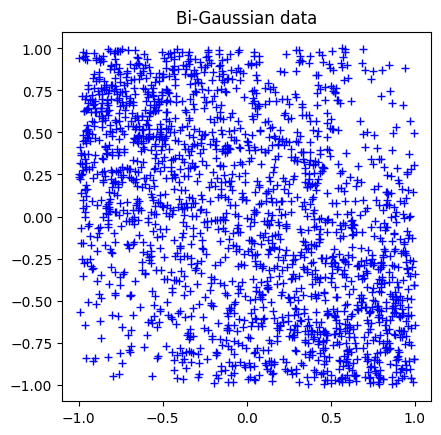

In [6]:
plt.plot(data_mat[:, 0], data_mat[:, 1], "+", color="blue")
plt.gca().set_aspect('equal')
plt.title("Bi-Gaussian data")
plt.show()

## 2. Preliminary computations

We compute the $N \times N$ kernel matrix $\mathbf{K}$ defined from the bi-Gaussian data and a Gaussian kernel (kernel parameter $\gamma = 16$), and compute its squared Frobenius norm.

In [7]:
kernel_p = 16
sq_kernel_p = 32

In [8]:
L2_IPs_DD = data_mat @ data_mat.T
L2_sq_norms_D = np.diag(L2_IPs_DD)
L2_sq_dists_DD = np.add.outer(L2_sq_norms_D, L2_sq_norms_D) - 2*L2_IPs_DD
K_mat = np.exp(-kernel_p*L2_sq_dists_DD)

K_Frob_sq = np.sum(K_mat**2)

## 3. Tool functions

Below, we implement functions for the error map $\mathfrak{R}$ and its gradient with respect to the coordinates of a Nyström sample.

In [9]:
## value of the squared kernel K^2
def sq_kernel(x, y, sq_kernel_p):
    return np.exp(-sq_kernel_p * np.sum((x - y)**2))

## gradient of K^2 with respect to the left entry
def sq_kernel_grad_left(sq_kernel_mat, first_loc, second_loc, i_x, i_y, sq_kernel_p):
    return -2 * sq_kernel_p * sq_kernel_mat[i_x, i_y] * (first_loc[i_x,:] - second_loc[i_y,:])

## gradient of K^2 with respect to the diagonal (always zero for Gaussian kernels)
def sq_kernel_grad_diag(x, sq_kernel_p):
    return 0

In [10]:
## value of the error map R
def R_val(S_loc, data_mat, L2_sq_norms_D, K_Frob_sq, sq_kernel_p):
    m = S_loc.shape[0]
    
    L2_IPs_SS = S_loc @ S_loc.T
    L2_sq_norms_S = np.diag(L2_IPs_SS)
    L2_sq_dists_SS = np.add.outer(L2_sq_norms_S, L2_sq_norms_S) - 2*L2_IPs_SS
    K_sq_SS_mat = np.exp(-sq_kernel_p*L2_sq_dists_SS)
    vSv = np.sum(K_sq_SS_mat)

    L2_IPs_SD = S_loc @ data_mat.T
    L2_sq_dists_SD = -2*L2_IPs_SD + L2_sq_norms_S.reshape((m, 1)) + L2_sq_norms_D
    K_sq_SD_mat = np.exp(-sq_kernel_p*L2_sq_dists_SD)
    vSw = np.sum(K_sq_SD_mat)

    return K_Frob_sq - vSw**2 / vSv

In [11]:
## gradient of the error map R
def R_grad(S_loc, data_mat, L2_sq_norms_D, m, N, d, sq_kernel_p):
    L2_IPs_SS = S_loc @ S_loc.T
    L2_sq_norms_S = np.diag(L2_IPs_SS)
    L2_sq_dists_SS = np.add.outer(L2_sq_norms_S, L2_sq_norms_S) - 2*L2_IPs_SS
    K_sq_SS_mat = np.exp(-sq_kernel_p*L2_sq_dists_SS)
    vSv = np.sum(K_sq_SS_mat)

    L2_IPs_SD = S_loc @ data_mat.T
    L2_sq_dists_SD = -2*L2_IPs_SD + L2_sq_norms_S.reshape((m, 1)) + L2_sq_norms_D
    K_sq_SD_mat = np.exp(-sq_kernel_p*L2_sq_dists_SD)
    vSw = np.sum(K_sq_SD_mat)

    grad_term_1 = np.zeros(m*d)
    grad_term_2 = np.zeros(m*d)

    for k in range(m):
        grad_term_1[k*d:(k+1)*d] = sq_kernel_grad_diag(S_loc[k,:], sq_kernel_p)

        for j in range(m):
            if j != k:
                grad_term_1[k*d:(k+1)*d] += 2*sq_kernel_grad_left(K_sq_SS_mat, S_loc, S_loc, k, j, sq_kernel_p)

        for j in range(N):
            grad_term_2[k*d:(k+1)*d] += sq_kernel_grad_left(K_sq_SD_mat, S_loc, data_mat, k, j, sq_kernel_p)

    return (vSw / vSv)**2 * grad_term_1 - 2 * (vSw / vSv) * grad_term_2

We next implement a function which performs gradient descents on the error map $\mathfrak{R}$ with a fixed step size.

In [12]:
## GD optimisation of the error map R
def R_GD_iterate(S_loc, data_mat, L2_sq_norms_D, K_Frob_sq, sq_kernel_p, step_size, n_iter, pb=True):
    m = S_loc.shape[0]
    N, d = data_mat.shape
    R_rec = []
    iter_rec = []

    R_rec.append(R_val(S_loc, data_mat, L2_sq_norms_D, K_Frob_sq, sq_kernel_p))
    iter_rec.append(0)
    
    if pb: # if progress bar is requested
        iter_range = tqdm(range(1, n_iter+1))
    else:
        iter_range = range(1, n_iter+1)

    for t in iter_range:
        grad = R_grad(S_loc, data_mat, L2_sq_norms_D, m, N, d, sq_kernel_p)   # compute the gradient
        S_loc = S_loc - step_size * grad.reshape((m, d))    # perform update step
    
        R_rec.append(R_val(S_loc, data_mat, L2_sq_norms_D, K_Frob_sq, sq_kernel_p)) # compute cost
        iter_rec.append(t)

    return {"S_loc": S_loc, "R_rec": R_rec, "iter_rec": iter_rec}

We may also consider stochastic approximations of the gradient of $\mathfrak{R}$, which are computed from uniform random samples of the data points.

Below, we implement a function which performs stochastic gradient descents on the error map $\mathfrak{R}$ with a fixed step size and fixed batch size.

In [13]:
def R_SGD_iterate(S_loc, data_mat, L2_sq_norms_D, K_Frob_sq, sq_kernel_p, step_size, n_iter, batch_size, rng=None, pb=True):
    if rng is None:
        rng = np.random.default_rng()

    m = S_loc.shape[0]
    N, d = data_mat.shape
    R_rec = []
    iter_rec = []

    R_rec.append(R_val(S_loc, data_mat, L2_sq_norms_D, K_Frob_sq, sq_kernel_p))
    iter_rec.append(0)
    
    resc_val = (N/batch_size)**2  # rescaling
    
    if pb: # if progress bar is requested
        iter_range = tqdm(range(1, n_iter+1))
    else:
        iter_range = range(1, n_iter+1)

    for t in iter_range:
        I_samp = rng.choice(N, batch_size, replace=True)    # sample indices for stochastic approx
        grad = resc_val * R_grad(S_loc, data_mat[I_samp,:], L2_sq_norms_D[I_samp], m, batch_size, d,
                                 sq_kernel_p)               # compute stochastic approx of gradient
        
        S_loc = S_loc - step_size * grad.reshape((m, d))    # perform update step
    
        R_rec.append(R_val(S_loc, data_mat, L2_sq_norms_D, K_Frob_sq, sq_kernel_p)) # compute cost
        iter_rec.append(t)

    return {"S_loc": S_loc, "R_rec": R_rec, "iter_rec": iter_rec}

Finally, we define a function which computes the values of the trace, Frobenius and spectral norm errors of the Nyström approximation induced by a set of landmark points.

In [14]:
## trace, Frobenius and spectral norm errors
def comp_Nystrom_errors(S_loc, data_mat, L2_sq_norms_D, kernel_p):
    m = S_loc.shape[0]

    L2_IPs_SS = S_loc @ S_loc.T
    L2_sq_norms_S = np.diag(L2_IPs_SS)
    L2_sq_dists_SS = np.add.outer(L2_sq_norms_S, L2_sq_norms_S) - 2*L2_IPs_SS
    K_SS_mat = np.exp(-kernel_p*L2_sq_dists_SS)

    L2_IPs_SD = S_loc @ data_mat.T
    L2_sq_dists_SD = -2*L2_IPs_SD + L2_sq_norms_S.reshape((m, 1)) + L2_sq_norms_D
    K_SD_mat = np.exp(-kernel_p*L2_sq_dists_SD)

    if m == 1:
        K_SS_inv_mat = 1 / K_SS_mat[0, 0]
        K_hat_mat = np.outer(K_SD_mat, K_SD_mat.conj()) * K_SS_inv_mat
    else:
        K_II_inv_mat = np.linalg.pinv(K_SS_mat, hermitian=True)
        K_hat_mat = K_SD_mat.conj().T @ K_II_inv_mat @ K_SD_mat
        
    err_mat = K_mat - K_hat_mat
    trace_err = sum(np.diag(err_mat).real)
    Frob_err = np.sqrt(np.sum((err_mat * err_mat.conj()).real))
    spec_err = np.linalg.norm(err_mat, 2)
    
    return({"trace_err": trace_err, "Frob_err": Frob_err, "spec_err": spec_err})

## 4. Experiments

We sample $m = 50$ columns of $\mathbf{K}$ uniformly at random (without replacement), corresponding to an initial Nyström sample $\mathcal{S}^{(0)}$.

In [15]:
m = 50
random_seed = 456

rng = np.random.default_rng(random_seed)
I_samp = rng.choice(N, m, replace=False)
S0_loc = data_mat[I_samp,:]

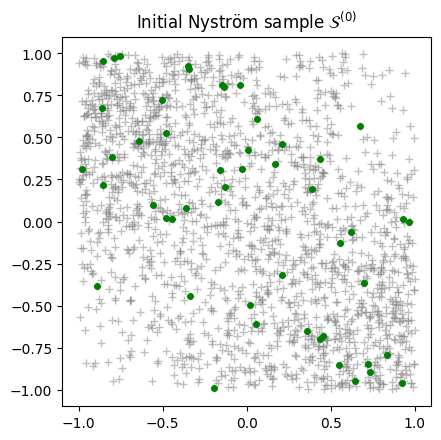

In [16]:
plt.plot(data_mat[:,0], data_mat[:,1], "+", color="grey", alpha=0.5)
plt.plot(S0_loc[:,0], S0_loc[:,1], "o", color="green", markersize=4)
plt.gca().set_aspect('equal')
plt.title("Initial Nyström sample $\mathcal{S}^{(0)}$")
plt.show()

### 4.1. Deterministic particle flow

We perform $400$ iterations of gradient descent with fixed step size on the error map $\mathfrak{R}$ initialised at $\mathcal{S}^{(0)}$.

In [17]:
step_size_GD = 0.000001
n_iter_GD = 400

GD_results = R_GD_iterate(S0_loc, data_mat, L2_sq_norms_D, K_Frob_sq, sq_kernel_p, step_size_GD, n_iter_GD)

100%|██████████| 400/400 [02:28<00:00,  2.70it/s]


We now plot the initial (green) and optimised (red) Nyström samples, and the decay of the error map $\mathfrak{R}$ over the iterations.

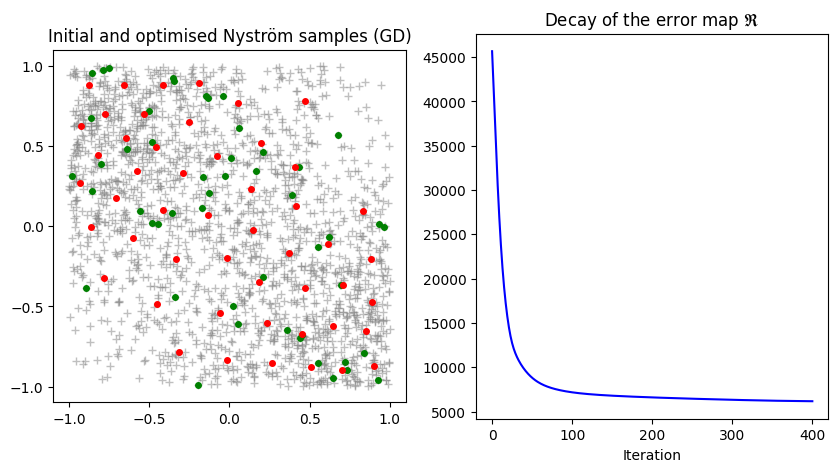

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(data_mat[:,0], data_mat[:,1], "+", color="grey", alpha=0.5)
ax[0].plot(S0_loc[:,0], S0_loc[:,1], "o", color="green", markersize=4)
ax[0].plot(GD_results["S_loc"][:,0], GD_results["S_loc"][:,1], "o", color="red", markersize=4)
ax[0].set_aspect("equal")
ax[0].xaxis.set_ticks(np.arange(-1, 1.5, 0.5))
ax[0].yaxis.set_ticks(np.arange(-1, 1.5, 0.5))
ax[0].set_title("Initial and optimised Nyström samples (GD)")

ax[1].plot(GD_results["iter_rec"], GD_results["R_rec"], color="blue")
ax[1].set_xlabel("Iteration")
ax[1].set_title("Decay of the error map $\mathfrak{R}$")
plt.show()

Plot the paths taken by the landmark points throughout the GD optimisation procedure.

In [19]:
rec_every = 5   ## how often to record the positions of the landmark points
n_rec = 80      ## number of recordings (5*80 = 400 iterations in total)

rec_path_GD = np.zeros((n_rec+1, m, 2))
S_loc = S0_loc
rec_path_GD[0,:,:] = S_loc 

for k in tqdm(np.arange(1, n_rec+1)):
    GD_evo_results = R_GD_iterate(S_loc, data_mat, L2_sq_norms_D, K_Frob_sq, sq_kernel_p, step_size_GD, n_iter=rec_every, pb=False)
    
    S_loc = GD_evo_results["S_loc"]
    rec_path_GD[k,:,:] = S_loc 

100%|██████████| 80/80 [02:09<00:00,  1.62s/it]


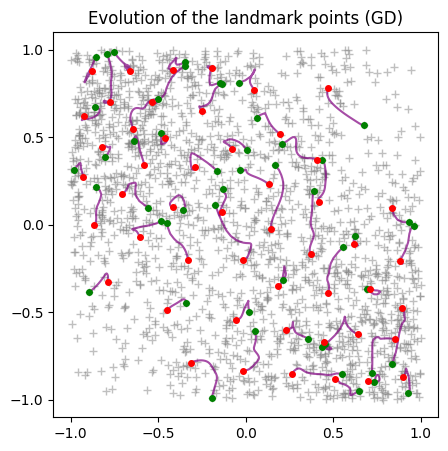

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(data_mat[:,0], data_mat[:,1], "+", color="grey", alpha=0.5)
ax.set_aspect("equal")
ax.xaxis.set_ticks(np.arange(-1, 1.5, 0.5))
ax.yaxis.set_ticks(np.arange(-1, 1.5, 0.5))

for pt in range(m):
    ax.plot(rec_path_GD[:, pt, 0], rec_path_GD[:, pt, 1], color="purple", alpha=0.7)
    
ax.plot(S0_loc[:,0], S0_loc[:,1], "o", color="green", markersize=4)
ax.plot(GD_results["S_loc"][:,0], GD_results["S_loc"][:,1], "o", color="red", markersize=4)
ax.set_title("Evolution of the landmark points (GD)")
plt.show()

### 4.2. Stochastic variant

We now perform $1200$ iterations of SGD on the error map $\mathfrak{R}$ initialised at $\mathcal{S}^{(0)}$ (batch size of $50$).

In [21]:
step_size_SGD = 0.0000002
n_iter_SGD = 1200
batch_size = 50
random_seed = 789

rng = np.random.default_rng(random_seed)
SGD_results = R_SGD_iterate(S0_loc, data_mat, L2_sq_norms_D, K_Frob_sq, sq_kernel_p, step_size_SGD, n_iter_SGD, batch_size, rng=rng)

100%|██████████| 1200/1200 [00:23<00:00, 51.20it/s]


As in the deterministic case, we illustrate the initial (green) and optimised (red) Nyström samples, and the decay of the error map $\mathfrak{R}$ over the iterations.

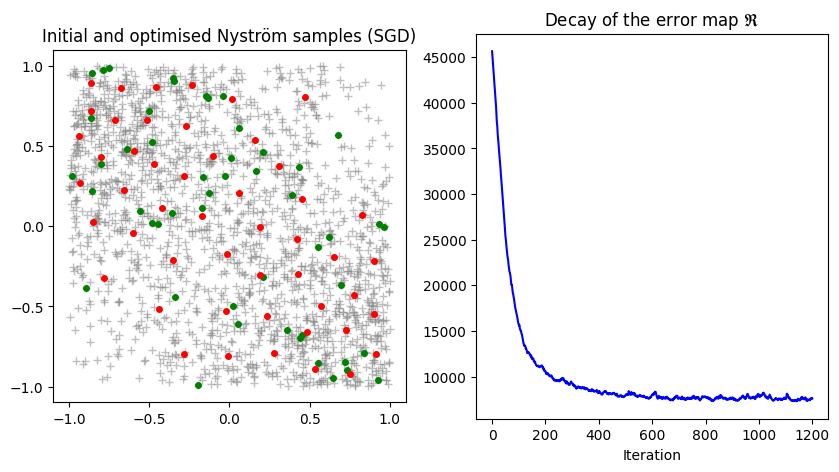

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(data_mat[:,0], data_mat[:,1], "+", color="grey", alpha=0.5)
ax[0].plot(S0_loc[:,0], S0_loc[:,1], "o", color="green", markersize=4)
ax[0].plot(SGD_results["S_loc"][:,0], SGD_results["S_loc"][:,1], "o", color="red", markersize=4)
ax[0].set_aspect("equal")
ax[0].xaxis.set_ticks(np.arange(-1, 1.5, 0.5))
ax[0].yaxis.set_ticks(np.arange(-1, 1.5, 0.5))
ax[0].set_title("Initial and optimised Nyström samples (SGD)")

ax[1].plot(SGD_results["iter_rec"], SGD_results["R_rec"], color="blue")
ax[1].set_xlabel("Iteration")
ax[1].set_title("Decay of the error map $\mathfrak{R}$")
plt.show()

Plot the paths taken by the landmark points throughout the SGD optimisation procedure.

In [23]:
rec_every = 5   ## how often to record the positions of the landmark points
n_rec = 240     ## number of recordings (5*240 = 1200 iterations in total)
random_seed = 789

rec_path_SGD = np.zeros((n_rec+1, m, 2))
S_loc = S0_loc
rec_path_SGD[0,:,:] = S_loc 
iter_evo_rec = np.zeros(n_rec+1)

rng = np.random.default_rng(random_seed)

for k in tqdm(np.arange(1, n_rec+1)):
    SGD_evo_results = R_SGD_iterate(S_loc, data_mat, L2_sq_norms_D, K_Frob_sq, sq_kernel_p, step_size_SGD, n_iter=rec_every, batch_size=50, rng=rng, pb=False)
    
    S_loc = SGD_evo_results["S_loc"]
    rec_path_SGD[k,:,:] = S_loc

100%|██████████| 240/240 [00:24<00:00,  9.86it/s]


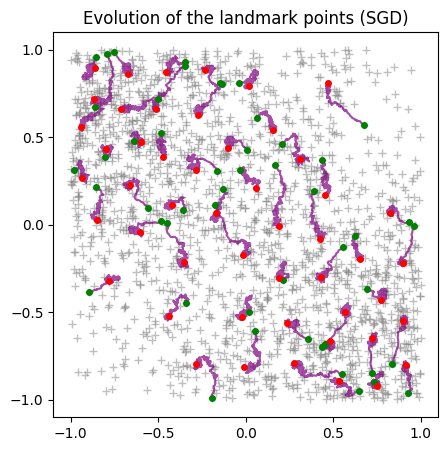

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(data_mat[:,0], data_mat[:,1], "+", color="grey", alpha=0.5)
ax.set_aspect("equal")
ax.xaxis.set_ticks(np.arange(-1, 1.5, 0.5))
ax.yaxis.set_ticks(np.arange(-1, 1.5, 0.5))

for pt in range(m):
    ax.plot(rec_path_SGD[:, pt, 0], rec_path_SGD[:, pt, 1], color="purple", alpha=0.7)
    
ax.plot(S0_loc[:,0], S0_loc[:,1], "o", color="green", markersize=4)
ax.plot(SGD_evo_results["S_loc"][:,0], SGD_evo_results["S_loc"][:,1], "o", color="red", markersize=4)
ax.set_title("Evolution of the landmark points (SGD)")
plt.show()

### 4.3. Approximation errors

We compute the trace, Frobenius and spectral norm errors of the Nyström approximations induced by the initial Nyström sample $\mathcal{S}^{(0)}$ ($m = 50$) and by the optimised Nyström samples obtained through the GD and SGD procedures.

In [25]:
initial_Nystrom_errors = comp_Nystrom_errors(S0_loc, data_mat, L2_sq_norms_D, kernel_p)
GD_Nystrom_errors = comp_Nystrom_errors(GD_results["S_loc"], data_mat, L2_sq_norms_D, kernel_p)
SGD_Nystrom_errors = comp_Nystrom_errors(SGD_results["S_loc"], data_mat, L2_sq_norms_D, kernel_p)

Nystrom_errors_df = pd.DataFrame.from_records([initial_Nystrom_errors, GD_Nystrom_errors, SGD_Nystrom_errors])
Nystrom_errors_df.insert(0, "Sample", ["Initial", "After GD", "After SGD"])

In [26]:
print(Nystrom_errors_df.to_markdown(index=False, tablefmt="grid"))

+-----------+-------------+------------+------------+
| Sample    |   trace_err |   Frob_err |   spec_err |
+===========+=============+============+============+
| Initial   |     560.243 |    99.8438 |    39.701  |
+-----------+-------------+------------+------------+
| After GD  |     302.91  |    46.172  |    17.0789 |
+-----------+-------------+------------+------------+
| After SGD |     320.978 |    49.9628 |    19.1139 |
+-----------+-------------+------------+------------+
